In [117]:
import sys
import os
import warnings

for p in [
    "/usr/lib/spark/python/lib/py4j-current-src.zip",
    "/usr/lib/spark/python",
]:
    while p in sys.path:
        sys.path.remove(p)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


np.random.seed(42)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [118]:
base_cols = [
    "dt",
    "lon_cell",
    "lat_cell",
    "cell_x",
    "cell_y",
    "horizon_min_dt",
    "horizon_max_dt",
]
target_col = "target"
feature_dir = "data/features"

def add_time_cols(df: pd.DataFrame) -> pd.DataFrame:
    df["dt_year"] = df["dt"].apply(lambda x: int(x.split("-")[0]))
    df["dt_month"] = df["dt"].apply(lambda x: int(x.split("-")[1]))
    df["dt_day"] = df["dt"].apply(lambda x: int(x.split("-")[2]))

    df["day_of_year"] = df[["dt_year", "dt_month", "dt_day"]].apply(
        lambda x: pd.Timestamp(x[0], x[1], x[2]).dayofyear, axis=1
    )
    df["day_of_year_sin"] = df[["dt_year", "dt_month", "dt_day"]].apply(
        lambda x: np.sin(
            2.0 * np.pi * pd.Timestamp(x[0], x[1], x[2]).dayofyear / float(pd.Timestamp(x[0], 12, 31).dayofyear)
        ),
        axis=1,
    )
    df["day_of_year_cos"] = df[["dt_year", "dt_month", "dt_day"]].apply(
        lambda x: np.cos(
            2.0 * np.pi * pd.Timestamp(x[0], x[1], x[2]).dayofyear / float(pd.Timestamp(x[0], 12, 31).dayofyear)
        ),
        axis=1,
    )

    df["day_of_month_sin"] = df[["dt_year", "dt_month", "dt_day"]].apply(
        lambda x: np.sin(2.0 * np.pi * float(x[1]) / float(pd.Timestamp(x[0], x[1], x[2]).days_in_month)), axis=1
    )
    df["day_of_month_cos"] = df[["dt_year", "dt_month", "dt_day"]].apply(
        lambda x: np.sin(2.0 * np.pi * float(x[1]) / float(pd.Timestamp(x[0], x[1], x[2]).days_in_month)), axis=1
    )

    return df
    
def join_feature_files(feature_set_paths: list[str], feature_dir: str) -> pd.DataFrame:
    features_df = None
    for f_name in tqdm(feature_set_paths):
        f_path = os.path.join(feature_dir, f_name)
        df = pd.read_csv(f_path, sep=";")
        col_names = df.columns.tolist()
        rename_cols_dict = {x:f"{x}_rad0" for x in col_names if ("count" in x or "magn" in x) and "rad" not in x}
        df = df.rename(columns=rename_cols_dict)
        if features_df is None:
            features_df = df.copy()
        else:
            existing_cols = set(features_df.columns)
            new_cols = list(set(df.columns) - existing_cols)
            select_cols = list(set(base_cols + new_cols + [target_col]))
            df = df[select_cols]
            features_df = features_df.merge(df, on=base_cols + [target_col], how="inner")

    return features_df

def get_features_dict(cols: list[str]) -> dict[int, list[int]]:
    return {
        r:np.sort(list(set([
            int(x.split("earthquakes_")[-1].split("_")[0])//365 
            for x in cols if "earthquakes" in x and f"rad{r}" in x
        ]))).tolist()
        for r in [0, 3, 5]
    }

def get_border_values(df: pd.DataFrame, col: str = "dt"):
    return np.sort(df[col].tolist())[0], np.sort(df[col].tolist())[-1]

def border_values_for_list(feature_set_paths: list[str]) -> None:
    for p in feature_set_paths:
        df = pd.read_csv(f"{feature_dir}/{p}", sep=";")
        print(get_border_values(df), p)
        
def print_some_stats(df: pd.DataFrame) -> None:
    print("len(df):                ", len(df))
    print("'dt' border values:     ", get_border_values(df))
    print("len(columns):           ", len(df.columns.tolist()))
    print("count target==1:        ", df["target"].sum())
    print("last dt, when target==1:", np.sort(df[df["target"]==1]["dt"].unique())[-1])
    print("\nfeatures_dict:")
    display(get_features_dict(df.columns))

In [119]:
! ls data/features

magn_3_5_aft_test_rad0_depth60_90_180_365_1095_1825_2555_3650.csv
magn_3_5_aft_test_rad3_depth60_90_180_365_1095_1825_2555_3650.csv
magn_3_5_aft_test_rad5_depth60_90_180_365_1095_1825_2555_3650.csv
magn_3_5_aft_train_rad0_depth60_90_180_365_1095_1825_2555_3650.csv
magn_3_5_aft_train_rad3_depth60_90_180_365_1095_1825_2555_3650.csv
magn_3_5_aft_train_rad5_depth60_90_180_365_1095_1825_2555_3650.csv
magn_3_5_withoutaft_test_rad0_depth60_90_180_365_1095_1825_2555_3650.csv
magn_3_5_withoutaft_test_rad3_depth60_90_180_365_1095_1825_2555_3650.csv
magn_3_5_withoutaft_test_rad5_depth60_90_180_365_1095_1825_2555_3650.csv
magn_3_5_withoutaft_train_rad0_depth60_90_180_365_1095_1825_2555_3650.csv
magn_3_5_withoutaft_train_rad3_depth60_90_180_365_1095_1825_2555_3650.csv
magn_3_5_withoutaft_train_rad5_depth60_90_180_365_1095_1825_2555_3650.csv
magn_6_aft_features_3_5_rad0_depth60_90_180_365_1095_1825_2555_3650_trs6.0.csv
magn_6_aft_features_3_5_rad3_depth60_90_180_365_1095_1825_2555_3650_trs6.0.csv
ma

## orig magn>3.5

### train

In [79]:
dataset_type = "magn_3_5_aft_train"
out_file = f"data/dataset/{dataset_type}.parquet"
feature_set_paths = [x for x in os.listdir(feature_dir) if dataset_type in x]

In [48]:
border_values_for_list(feature_set_paths)

('2009-03-17', '2020-08-26') magn_3_5_aft_train_rad0_depth60_90_180_365_1095_1825_2555_3650.csv
('2009-03-17', '2020-08-26') magn_3_5_aft_train_rad3_depth60_90_180_365_1095_1825_2555_3650.csv
('2009-03-17', '2020-08-26') magn_3_5_aft_train_rad5_depth60_90_180_365_1095_1825_2555_3650.csv


In [49]:
df_magn_3_5_aft_train = join_feature_files(feature_set_paths, feature_dir)

100%|██████████| 3/3 [00:31<00:00, 10.36s/it]


In [50]:
df_magn_3_5_aft_train = add_time_cols(df_magn_3_5_aft_train)

In [51]:
print_some_stats(df_magn_3_5_aft_train)

len(df):                 2878949
'dt' border values:      ('2009-03-17', '2020-08-26')
len(columns):            136
count target==1:         66242
last dt, when target==1: 2020-08-26

features_dict:


{0: [0, 1, 3, 5, 7, 10], 3: [0, 1, 3, 5, 7, 10], 5: [0, 1, 3, 5, 7, 10]}

In [52]:
df_magn_3_5_aft_train.to_parquet(out_file, index=False)

In [80]:
df_magn_3_5_aft_train = pd.read_parquet(out_file)

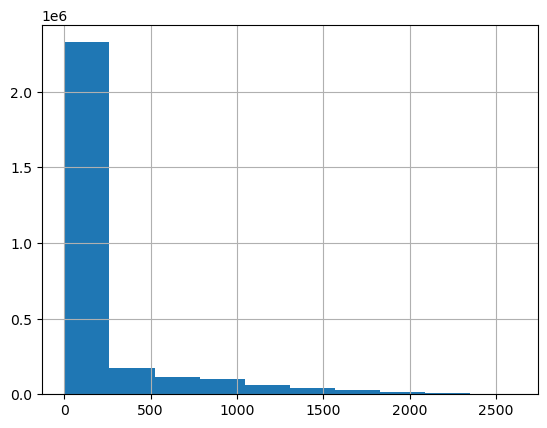

In [86]:
df_magn_3_5_aft_train[df_magn_3_5_aft_train["count_earthquakes_3650_rad5"] > 0.0]["count_earthquakes_3650_rad5"].hist();

### test

In [87]:
dataset_type = "magn_3_5_aft_test"
out_file = f"data/dataset/{dataset_type}.parquet"
feature_set_paths = [x for x in os.listdir(feature_dir) if dataset_type in x]

In [54]:
border_values_for_list(feature_set_paths)

('2020-10-14', '2023-05-21') magn_3_5_aft_test_rad5_depth60_90_180_365_1095_1825_2555_3650.csv
('2020-10-14', '2023-05-21') magn_3_5_aft_test_rad3_depth60_90_180_365_1095_1825_2555_3650.csv
('2020-10-14', '2023-05-21') magn_3_5_aft_test_rad0_depth60_90_180_365_1095_1825_2555_3650.csv


In [55]:
df_magn_3_5_aft_test = join_feature_files(feature_set_paths, feature_dir)

100%|██████████| 3/3 [01:14<00:00, 24.81s/it]


In [56]:
df_magn_3_5_aft_test = add_time_cols(df_magn_3_5_aft_test)

In [57]:
print_some_stats(df_magn_3_5_aft_test)

len(df):                 6527450
'dt' border values:      ('2020-10-14', '2023-05-21')
len(columns):            136
count target==1:         98518
last dt, when target==1: 2023-05-21

features_dict:


{0: [0, 1, 3, 5, 7, 10], 3: [0, 1, 3, 5, 7, 10], 5: [0, 1, 3, 5, 7, 10]}

In [58]:
df_magn_3_5_aft_test.to_parquet(out_file, index=False)

In [88]:
df_magn_3_5_aft_test = pd.read_parquet(out_file)

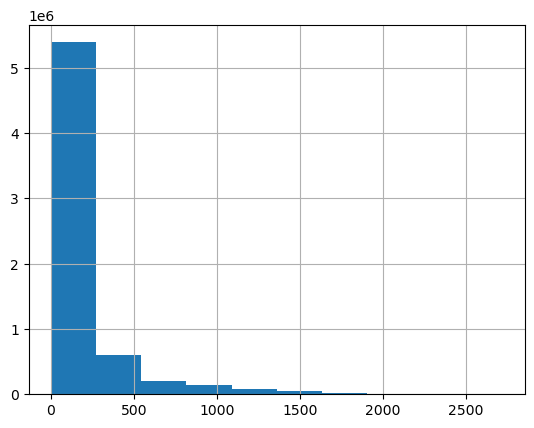

In [89]:
df_magn_3_5_aft_test[df_magn_3_5_aft_test["count_earthquakes_3650_rad5"] > 0.0]["count_earthquakes_3650_rad5"].hist();

## withoutaft magn>3.5

### train

In [33]:
dataset_type = "magn_3_5_withoutaft_train"
out_file = f"data/dataset/{dataset_type}.parquet"
feature_set_paths = [x for x in os.listdir(feature_dir) if dataset_type in x]

In [34]:
border_values_for_list(feature_set_paths)

('2009-03-17', '2023-05-23') magn_3_5_withoutaft_train_rad0_depth60_90_180_365_1095_1825_2555_3650.csv
('2009-03-17', '2023-05-23') magn_3_5_withoutaft_train_rad5_depth60_90_180_365_1095_1825_2555_3650.csv
('2009-03-17', '2023-05-23') magn_3_5_withoutaft_train_rad3_depth60_90_180_365_1095_1825_2555_3650.csv


In [35]:
df_magn_3_5_withoutaft_train = join_feature_files(feature_set_paths, feature_dir)

100%|██████████| 3/3 [00:24<00:00,  8.23s/it]


In [36]:
print_some_stats(df_magn_3_5_withoutaft_train)

len(df):                 2460060
'dt' border values:      ('2009-03-17', '2023-05-23')
len(columns):            128
count target==1:         20130
last dt, when target==1: 2023-05-23

features_dict:


{0: [0, 1, 3, 5, 7, 10], 3: [0, 1, 3, 5, 7, 10], 5: [0, 1, 3, 5, 7, 10]}

In [37]:
df_magn_3_5_withoutaft_train = add_time_cols(df_magn_3_5_withoutaft_train)

In [38]:
print_some_stats(df_magn_3_5_withoutaft_train)

len(df):                 2460060
'dt' border values:      ('2009-03-17', '2023-05-23')
len(columns):            136
count target==1:         20130
last dt, when target==1: 2023-05-23

features_dict:


{0: [0, 1, 3, 5, 7, 10], 3: [0, 1, 3, 5, 7, 10], 5: [0, 1, 3, 5, 7, 10]}

In [39]:
df_magn_3_5_withoutaft_train.to_parquet(out_file, index=False)

### test

In [40]:
dataset_type = "magn_3_5_withoutaft_test"
out_file = f"data/dataset/{dataset_type}.parquet"
feature_set_paths = [x for x in os.listdir(feature_dir) if dataset_type in x]

In [41]:
border_values_for_list(feature_set_paths)

('2020-10-14', '2023-05-21') magn_3_5_withoutaft_test_rad3_depth60_90_180_365_1095_1825_2555_3650.csv
('2020-10-14', '2023-05-21') magn_3_5_withoutaft_test_rad5_depth60_90_180_365_1095_1825_2555_3650.csv
('2020-10-14', '2023-05-21') magn_3_5_withoutaft_test_rad0_depth60_90_180_365_1095_1825_2555_3650.csv


In [42]:
df_magn_3_5_withoutaft_test = join_feature_files(feature_set_paths, feature_dir)

100%|██████████| 3/3 [00:44<00:00, 14.74s/it]


In [43]:
print_some_stats(df_magn_3_5_withoutaft_test)

len(df):                 4503000
'dt' border values:      ('2020-10-14', '2023-05-21')
len(columns):            128
count target==1:         41093
last dt, when target==1: 2023-05-21

features_dict:


{0: [0, 1, 3, 5, 7, 10], 3: [0, 1, 3, 5, 7, 10], 5: [0, 1, 3, 5, 7, 10]}

In [44]:
df_magn_3_5_withoutaft_test = add_time_cols(df_magn_3_5_withoutaft_test)

In [45]:
print_some_stats(df_magn_3_5_withoutaft_test)

len(df):                 4503000
'dt' border values:      ('2020-10-14', '2023-05-21')
len(columns):            136
count target==1:         41093
last dt, when target==1: 2023-05-21

features_dict:


{0: [0, 1, 3, 5, 7, 10], 3: [0, 1, 3, 5, 7, 10], 5: [0, 1, 3, 5, 7, 10]}

In [46]:
df_magn_3_5_withoutaft_test.to_parquet(out_file, index=False)

## orig magn>6.0

### features based on magn>6.0

In [7]:
dataset_type = "magn_6_aft"
out_file = f"data/dataset/{dataset_type}.parquet"
feature_set_paths = [x for x in os.listdir(feature_dir) if dataset_type in x]

In [8]:
feature_set_paths

['magn_6_aft_rad3_depth60_90_180_365_1095_1825_2555_3650.csv',
 'magn_6_aft_rad0_depth60_90_180_365_1095_1825_2555_3650.csv',
 'magn_6_aft_rad5_depth60_90_180_365_1095_1825_2555_3650.csv']

In [9]:
border_values_for_list(feature_set_paths)

('2009-05-31', '2023-05-10') magn_6_aft_rad3_depth60_90_180_365_1095_1825_2555_3650.csv
('2009-05-31', '2023-05-10') magn_6_aft_rad0_depth60_90_180_365_1095_1825_2555_3650.csv
('2009-05-31', '2023-05-10') magn_6_aft_rad5_depth60_90_180_365_1095_1825_2555_3650.csv


In [10]:
df_magn_6_aft = join_feature_files(feature_set_paths, feature_dir)

100%|██████████| 3/3 [00:53<00:00, 17.72s/it]


In [12]:
df_magn_6_aft["target"].sum()

7909

In [14]:
df_magn_6_aft = add_time_cols(df_magn_6_aft)

In [19]:
print_some_stats(df_magn_6_aft)

len(df):                 5520812
'dt' border values:      ('2009-05-31', '2023-05-10')
len(columns):            136
count target==1:         7909
last dt, when target==1: 2023-05-10

features_dict:


{0: [0, 1, 3, 5, 7, 10], 3: [0, 1, 3, 5, 7, 10], 5: [0, 1, 3, 5, 7, 10]}

In [24]:
df_magn_6_aft.to_parquet(out_file, index=False)

### features based on magn>3.5

In [120]:
dataset_type = "magn_6_aft_features_3_5"
out_file = f"data/dataset/{dataset_type}.parquet"
feature_set_paths = [x for x in os.listdir(feature_dir) if dataset_type in x]

In [121]:
feature_set_paths

['magn_6_aft_features_3_5_rad3_depth60_90_180_365_1095_1825_2555_3650_trs6.0.csv',
 'magn_6_aft_features_3_5_rad0_depth60_90_180_365_1095_1825_2555_3650_trs6.0.csv',
 'magn_6_aft_features_3_5_rad5_depth60_90_180_365_1095_1825_2555_3650_trs6.0.csv']

In [9]:
border_values_for_list(feature_set_paths)

('2009-05-31', '2023-05-10') magn_6_aft_rad3_depth60_90_180_365_1095_1825_2555_3650.csv
('2009-05-31', '2023-05-10') magn_6_aft_rad0_depth60_90_180_365_1095_1825_2555_3650.csv
('2009-05-31', '2023-05-10') magn_6_aft_rad5_depth60_90_180_365_1095_1825_2555_3650.csv


In [122]:
df_magn_6_aft = join_feature_files(feature_set_paths, feature_dir)

100%|██████████| 3/3 [00:10<00:00,  3.45s/it]


In [123]:
df_magn_6_aft["target"].sum()

7156

In [124]:
df_magn_6_aft = add_time_cols(df_magn_6_aft)

In [125]:
print_some_stats(df_magn_6_aft)

len(df):                 920925
'dt' border values:      ('2009-05-31', '2020-08-13')
len(columns):            136
count target==1:         7156
last dt, when target==1: 2020-08-13

features_dict:


{0: [0, 1, 3, 5, 7, 10], 3: [0, 1, 3, 5, 7, 10], 5: [0, 1, 3, 5, 7, 10]}

In [126]:
df_magn_6_aft.to_parquet(out_file, index=False)

In [127]:
dataset_type = "magn_6_aft_test_features_3_5"
out_file = f"data/dataset/{dataset_type}.parquet"
feature_set_paths = [x for x in os.listdir(feature_dir) if dataset_type in x]

In [128]:
feature_set_paths

['magn_6_aft_test_features_3_5_rad0_3_5_depth60_90_180_365_1095_1825_2555_3650_trs6.0.csv']

In [129]:
border_values_for_list(feature_set_paths)

('2020-10-02', '2023-05-09') magn_6_aft_test_features_3_5_rad0_3_5_depth60_90_180_365_1095_1825_2555_3650_trs6.0.csv


In [130]:
df_magn_6_aft = join_feature_files(feature_set_paths, feature_dir)

100%|██████████| 1/1 [00:01<00:00,  1.50s/it]


In [131]:
df_magn_6_aft["target"].sum()

730

In [132]:
df_magn_6_aft = add_time_cols(df_magn_6_aft)

In [133]:
print_some_stats(df_magn_6_aft)

len(df):                 213750
'dt' border values:      ('2020-10-02', '2023-05-09')
len(columns):            136
count target==1:         730
last dt, when target==1: 2023-05-09

features_dict:


{0: [0, 1, 3, 5, 7, 10], 3: [0, 1, 3, 5, 7, 10], 5: [0, 1, 3, 5, 7, 10]}

In [134]:
df_magn_6_aft.to_parquet(out_file, index=False)

## withoutaft magn>6.0

### features based on magn>6

In [25]:
dataset_type = "magn_6_withoutaft"
out_file = f"data/dataset/{dataset_type}.parquet"
feature_set_paths = [x for x in os.listdir(feature_dir) if dataset_type in x]

In [26]:
feature_set_paths

['magn_6_withoutaft_rad0_3_5_depth60_90_180_365_1095_1825_2555_3650.csv']

In [27]:
border_values_for_list(feature_set_paths)

('2009-05-31', '2023-05-10') magn_6_withoutaft_rad0_3_5_depth60_90_180_365_1095_1825_2555_3650.csv


In [28]:
df_magn_6_withoutaft = join_feature_files(feature_set_paths, feature_dir)

100%|██████████| 1/1 [00:15<00:00, 15.11s/it]


In [29]:
df_magn_6_withoutaft["target"].sum()

3115

In [30]:
df_magn_6_withoutaft = add_time_cols(df_magn_6_withoutaft)

In [31]:
print_some_stats(df_magn_6_withoutaft)

len(df):                 2363152
'dt' border values:      ('2009-05-31', '2023-05-10')
len(columns):            136
count target==1:         3115
last dt, when target==1: 2023-05-10

features_dict:


{0: [0, 1, 3, 5, 7, 10], 3: [0, 1, 3, 5, 7, 10], 5: [0, 1, 3, 5, 7, 10]}

In [32]:
df_magn_6_withoutaft.to_parquet(out_file, index=False)

### features based on magn>3.5

In [136]:
dataset_type = "magn_6_withoutaft_features_3_5"
out_file = f"data/dataset/{dataset_type}.parquet"
feature_set_paths = [x for x in os.listdir(feature_dir) if dataset_type in x]

In [137]:
feature_set_paths

['magn_6_withoutaft_features_3_5_rad5_depth60_90_180_365_1095_1825_2555_3650_trs6.0.csv',
 'magn_6_withoutaft_features_3_5_rad3_depth60_90_180_365_1095_1825_2555_3650_trs6.0.csv',
 'magn_6_withoutaft_features_3_5_rad0_depth60_90_180_365_1095_1825_2555_3650_trs6.0.csv']

In [138]:
border_values_for_list(feature_set_paths)

('2009-05-31', '2020-08-13') magn_6_withoutaft_features_3_5_rad5_depth60_90_180_365_1095_1825_2555_3650_trs6.0.csv
('2009-05-31', '2020-08-13') magn_6_withoutaft_features_3_5_rad3_depth60_90_180_365_1095_1825_2555_3650_trs6.0.csv
('2009-05-31', '2020-08-13') magn_6_withoutaft_features_3_5_rad0_depth60_90_180_365_1095_1825_2555_3650_trs6.0.csv


In [139]:
df_magn_6_withoutaft = join_feature_files(feature_set_paths, feature_dir)

100%|██████████| 3/3 [00:03<00:00,  1.21s/it]


In [140]:
df_magn_6_withoutaft["target"].sum()

2600

In [141]:
df_magn_6_withoutaft = add_time_cols(df_magn_6_withoutaft)

In [142]:
print_some_stats(df_magn_6_withoutaft)

len(df):                 417486
'dt' border values:      ('2009-05-31', '2020-08-13')
len(columns):            136
count target==1:         2600
last dt, when target==1: 2020-06-14

features_dict:


{0: [0, 1, 3, 5, 7, 10], 3: [0, 1, 3, 5, 7, 10], 5: [0, 1, 3, 5, 7, 10]}

In [143]:
df_magn_6_withoutaft.to_parquet(out_file, index=False)

In [144]:
dataset_type = "magn_6_test_withoutaft_features_3_5"
out_file = f"data/dataset/{dataset_type}.parquet"
feature_set_paths = [x for x in os.listdir(feature_dir) if dataset_type in x]

In [145]:
feature_set_paths

[]

In [146]:
border_values_for_list(feature_set_paths)

In [147]:
df_magn_6_withoutaft = join_feature_files(feature_set_paths, feature_dir)

0it [00:00, ?it/s]


In [148]:
df_magn_6_withoutaft["target"].sum()

TypeError: 'NoneType' object is not subscriptable

In [ ]:
df_magn_6_withoutaft = add_time_cols(df_magn_6_withoutaft)

In [ ]:
print_some_stats(df_magn_6_withoutaft)

In [ ]:
df_magn_6_withoutaft.to_parquet(out_file, index=False)

## trs 6.0

## orig magn>6.0

### train

In [59]:
dataset_type = "magn_6_aft"
out_file = f"data/dataset/{dataset_type}_trs6.0.parquet"
feature_set_paths = [x for x in os.listdir(feature_dir) if dataset_type in x and "trs6" in x and "test" not in x]

In [60]:
feature_set_paths

['magn_6_aft_rad3_depth60_90_180_365_1095_1825_2555_3650_trs6.0.csv',
 'magn_6_aft_rad5_depth60_90_180_365_1095_1825_2555_3650_trs6.0.csv',
 'magn_6_aft_rad0_depth60_90_180_365_1095_1825_2555_3650_trs6.0.csv']

In [61]:
border_values_for_list(feature_set_paths)

('2009-05-31', '2020-08-13') magn_6_aft_rad3_depth60_90_180_365_1095_1825_2555_3650_trs6.0.csv
('2009-05-31', '2020-08-13') magn_6_aft_rad5_depth60_90_180_365_1095_1825_2555_3650_trs6.0.csv
('2009-05-31', '2020-08-13') magn_6_aft_rad0_depth60_90_180_365_1095_1825_2555_3650_trs6.0.csv


In [62]:
df_magn_6_aft = join_feature_files(feature_set_paths, feature_dir)

100%|██████████| 3/3 [00:09<00:00,  3.03s/it]


In [63]:
df_magn_6_aft["target"].sum()

7156

In [64]:
df_magn_6_aft = add_time_cols(df_magn_6_aft)

In [66]:
print_some_stats(df_magn_6_aft)

len(df):                 920925
'dt' border values:      ('2009-05-31', '2020-08-13')
len(columns):            136
count target==1:         7156
last dt, when target==1: 2020-08-13

features_dict:


{0: [0, 1, 3, 5, 7, 10], 3: [0, 1, 3, 5, 7, 10], 5: [0, 1, 3, 5, 7, 10]}

In [75]:
7_909 / 5520812, 7156 / 920925

(0.0014325791206076207, 0.007770448190677851)

In [68]:
df_magn_6_aft.to_parquet(out_file, index=False)

### test

In [90]:
dataset_type = "magn_6_aft_test"
out_file = f"data/dataset/{dataset_type}_trs6.0.parquet"
feature_set_paths = [x for x in os.listdir(feature_dir) if dataset_type in x and "trs6" in x]

In [91]:
feature_set_paths

['magn_6_aft_test_rad0_3_5_depth60_90_180_365_1095_1825_2555_3650_trs6.0.csv']

In [92]:
border_values_for_list(feature_set_paths)

('2020-10-02', '2023-05-09') magn_6_aft_test_rad0_3_5_depth60_90_180_365_1095_1825_2555_3650_trs6.0.csv


In [93]:
df_magn_6_aft = join_feature_files(feature_set_paths, feature_dir)

100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


In [94]:
df_magn_6_aft["target"].sum()

730

In [95]:
df_magn_6_aft = add_time_cols(df_magn_6_aft)

In [96]:
print_some_stats(df_magn_6_aft)

len(df):                 213750
'dt' border values:      ('2020-10-02', '2023-05-09')
len(columns):            136
count target==1:         730
last dt, when target==1: 2023-05-09

features_dict:


{0: [0, 1, 3, 5, 7, 10], 3: [0, 1, 3, 5, 7, 10], 5: [0, 1, 3, 5, 7, 10]}

In [97]:
df_magn_6_aft.to_parquet(out_file, index=False)

## withoutaft magn>6.0

### train

In [69]:
dataset_type = "magn_6_withoutaft"
out_file = f"data/dataset/{dataset_type}_trs6.0.parquet"
feature_set_paths = [x for x in os.listdir(feature_dir) if dataset_type in x and "trs6" in x and "test" not in x]

In [70]:
feature_set_paths

['magn_6_withoutaft_rad0_depth60_90_180_365_1095_1825_2555_3650_trs6.0.csv',
 'magn_6_withoutaft_rad5_depth60_90_180_365_1095_1825_2555_3650_trs6.0.csv',
 'magn_6_withoutaft_rad3_depth60_90_180_365_1095_1825_2555_3650_trs6.0.csv']

In [71]:
border_values_for_list(feature_set_paths)

('2009-05-31', '2020-08-13') magn_6_withoutaft_rad0_depth60_90_180_365_1095_1825_2555_3650_trs6.0.csv
('2009-05-31', '2020-08-13') magn_6_withoutaft_rad5_depth60_90_180_365_1095_1825_2555_3650_trs6.0.csv
('2009-05-31', '2020-08-13') magn_6_withoutaft_rad3_depth60_90_180_365_1095_1825_2555_3650_trs6.0.csv


In [72]:
df_magn_6_withoutaft = join_feature_files(feature_set_paths, feature_dir)

100%|██████████| 3/3 [00:04<00:00,  1.34s/it]


In [73]:
df_magn_6_withoutaft["target"].sum()

2600

In [74]:
df_magn_6_withoutaft = add_time_cols(df_magn_6_withoutaft)

In [76]:
print_some_stats(df_magn_6_withoutaft)

len(df):                 417486
'dt' border values:      ('2009-05-31', '2020-08-13')
len(columns):            136
count target==1:         2600
last dt, when target==1: 2020-06-14

features_dict:


{0: [0, 1, 3, 5, 7, 10], 3: [0, 1, 3, 5, 7, 10], 5: [0, 1, 3, 5, 7, 10]}

In [77]:
3115 / 2363152, 2600 / 417486

(0.0013181547357089176, 0.006227753745035761)

In [78]:
df_magn_6_withoutaft.to_parquet(out_file, index=False)

### test

In [98]:
dataset_type = "magn_6_withoutaft_test"
out_file = f"data/dataset/{dataset_type}_trs6.0.parquet"
feature_set_paths = [x for x in os.listdir(feature_dir) if dataset_type in x and "trs6" in x]

In [99]:
feature_set_paths

['magn_6_withoutaft_test_rad0_3_5_depth60_90_180_365_1095_1825_2555_3650_trs6.0.csv']

In [100]:
border_values_for_list(feature_set_paths)

('2020-10-02', '2023-05-09') magn_6_withoutaft_test_rad0_3_5_depth60_90_180_365_1095_1825_2555_3650_trs6.0.csv


In [101]:
df_magn_6_withoutaft = join_feature_files(feature_set_paths, feature_dir)

100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


In [102]:
df_magn_6_withoutaft["target"].sum()

513

In [103]:
df_magn_6_withoutaft = add_time_cols(df_magn_6_withoutaft)

In [104]:
print_some_stats(df_magn_6_withoutaft)

len(df):                 96900
'dt' border values:      ('2020-10-02', '2023-05-09')
len(columns):            136
count target==1:         513
last dt, when target==1: 2023-05-09

features_dict:


{0: [0, 1, 3, 5, 7, 10], 3: [0, 1, 3, 5, 7, 10], 5: [0, 1, 3, 5, 7, 10]}

In [105]:
df_magn_6_withoutaft.to_parquet(out_file, index=False)